In [5]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageTk
import cv2
import keras_ocr
from scipy.spatial.distance import cdist
import tkinter as tk
from tkinter import simpledialog, messagebox

C:\Users\benst\AppData\Local\Temp\ipykernel_25668\549940493.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## get metadata
- import file containing metadata for the process

In [39]:
def get_metadata(ID):
    metadata = pd.read_csv(os.path.join('inputs\metadata', ID +'.csv'))
    return metadata

## define ROI
- user marks region of interest (ROI) for the heatmap data
- region outside of this is set to black

In [40]:
def define_roi(ID):
    drawing = False  
    points = []  

    def draw_boundary(event, x, y, flags, param):
        nonlocal drawing, points

        if event == cv2.EVENT_LBUTTONDOWN:
            drawing = True
            points = [(x, y)]

        elif event == cv2.EVENT_MOUSEMOVE:
            if drawing:
                points.append((x, y))

        elif event == cv2.EVENT_LBUTTONUP:
            drawing = False
            points.append((x, y))

    image = cv2.imread(os.path.join('inputs\efficiency_maps', ID +'.png'))
    result = image.copy()  # Create a copy of the image for drawing purposes
    cv2.namedWindow('Image')
    cv2.setMouseCallback('Image', draw_boundary)

    while True:
        for i in range(1, len(points)):
            cv2.line(result, points[i - 1], points[i], (0, 0, 255), 2)
        cv2.imshow('Image', result)

        key = cv2.waitKey(1) & 0xFF

        # Reset the image if 'r' is pressed
        if key == ord('r'):
            result = image.copy()
            points = []

        # Break the loop if 'q' is pressed
        elif key == ord('q'):
            break

    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [np.array(points)], (255, 255, 255))
    
    cv2.destroyAllWindows()

    return mask

## get scale
- scale a one pixel width copy of the scale image by the range of efficiencies
- if rgb's span multiple efficiencies (assumtpion they will no be separated by much) then take the mean efficiency over the rgb's
- get distinct grayscale value of the scale

In [41]:
def get_scale(ID, metadata):
    scale_image = Image.open(os.path.join('inputs\scales', ID +'.png'))
    scale_image = scale_image.convert("RGB")
    gs_scale_image = scale_image.convert("L")
    grayscale_array = np.array(gs_scale_image)
    array = np.array([x[0] for x in grayscale_array])
    seen = set()
    grayscale = []
    for i in array:
        if i not in seen:
            seen.add(i)
            grayscale.append(i)

    scale = np.array(scale_image)
    scale = scale[:,0,:3]

    su = metadata[metadata['Dim'] == 'SU']['z'].values[0]
    sl = metadata[metadata['Dim'] == 'SL']['z'].values[0]
    scale_range = su - sl

    scale_items = scale.shape[0]
    scale_fidelity = scale_range / scale_items
    z_values = (np.arange(1, scale_items + 1) * scale_fidelity) + sl
    z_values = z_values[::-1] # invert as is from large to small in scale
    z_values_df = pd.DataFrame(z_values, columns=['z'])
    scale_df = pd.DataFrame(scale, columns=['r', 'g', 'b'])
    scale_df = scale_df.join(z_values_df)
    scale_df = (scale_df.groupby(['r','g','b']).agg(z_mean=('z', 'mean'))).reset_index()
    scale = scale_df.values.astype(np.uint8)

    return scale, grayscale

## get efficiency map

#### infill text
- read cropped efficiency map image 
- use a bounding box ocr to identify text
- inpaint these regions

In [42]:
# infill text using ocr

def infill_text(ID):

    def midpoint(x1, y1, x2, y2):
        x_mid = int((x1 + x2)/2)
        y_mid = int((y1 + y2)/2)
        return (x_mid, y_mid)

    pipeline = keras_ocr.pipeline.Pipeline()

    img = keras_ocr.tools.read(os.path.join('inputs\efficiency_maps', ID +'.png'))

    prediction_groups = pipeline.recognize([img])
    mask = np.zeros(img.shape[:2], dtype="uint8")
    for box in prediction_groups[0]:
        x0, y0 = box[1][0]
        x1, y1 = box[1][1] 
        x2, y2 = box[1][2]
        x3, y3 = box[1][3] 
        
        x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
        x_mid1, y_mi1 = midpoint(x0, y0, x3, y3)
        
        thickness = int(math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))
        
        cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mi1), 255,    
        thickness)
        img = cv2.inpaint(img, mask, 7, cv2.INPAINT_NS)
                    
    return(img)

In [43]:
def gaussian_blur(im):
    import cv2

    blurred = cv2.GaussianBlur(im, (5, 5), 0)

    return blurred

#### infill lines and egdes
- convert image output to grayscale
- Use Canny edge detection to identify edges
- inpaint these extended by a region

In [44]:
def infill_lines(im):

    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(gray, 50, 150)

    # Create a mask by dilating the edges
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.dilate(edges, kernel, iterations=1)

    nolines = cv2.inpaint(im, mask, inpaintRadius=3, flags=cv2.INPAINT_NS)

    return nolines

#### infill not in scale
- infill regions where the pixel values are not in the scale (or white)

In [45]:
def infill_not_in_scale(im, grayscale):

    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    _white = [255] # these are black and close to black
    in_grayscale = grayscale + _white

    mask = np.ones_like(gray) * 255  # Initialize mask with all white pixels
    for value in in_grayscale:
        mask[gray == value] = 0  # Set pixels with predefined grayscale values to black in the mask

    inscale = cv2.inpaint(im, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    return inscale

In [46]:
def apply_roi(im, mask_roi):
    im[mask_roi == 0] = [0, 0, 0]

    return im

## make efficiency lookup
- map the efficiency map image dimensions to the speed/torque dimensions from metadata
- map rbg's to efficiencies from the scale data
- produce speed, torque, efficiency mapping for pixels that are in the scale and output to csv

In [76]:
def efficiency_lookup(im, scale):
    x_rl = metadata[metadata['Dim'] == 'RL']['x'].values[0]
    x_ll = metadata[metadata['Dim'] == 'LL']['x'].values[0]
    max_xi = im.shape[1] - 1

    y_lu = metadata[metadata['Dim'] == 'LU']['y'].values[0]
    y_ll = metadata[metadata['Dim'] == 'LL']['y'].values[0]
    max_yi = im.shape[0] - 1

    x = []
    y = []
    z = []

    def find_closest_rgb(pixel, scale):
        if not np.all(pixel == [0, 0, 0]):
            distances = cdist([pixel], scale[:,:3])
            closest_index = np.argmin(distances)
            zval = scale[closest_index][3]
        else:
            zval = 0
        return zval

    for xi in range(im.shape[1]):
        for yi in range(im.shape[0]):
            xbar = ((x_rl - x_ll) * xi) / max_xi
            ybar = ((y_lu - y_ll) * (max_yi - yi)) / max_yi
            zi = find_closest_rgb(im[yi, xi], scale)
            x.append(xbar)
            y.append(ybar)
            z.append(zi)

    efficiency_lookup_df = pd.DataFrame(zip(x,y,z),columns=(['speed','torque','efficiency']))

    return efficiency_lookup_df

## display the processed efficiency map lookup as a heatmap

In [48]:
def efficiency_heatmap(efficiency_lookup_df):
    heatmap_data = efficiency_lookup_df.pivot_table(index='torque', columns='speed', values='efficiency')
    heatmap_data = heatmap_data.iloc[::-1]

    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, cmap='viridis')
    plt.title('Efficiency Heatmap')
    plt.xlabel('Speed')
    plt.ylabel('Torque')
    plt.show()

## main

In [80]:
#ID = 'HDSRM300'
#ID = 'YASA_P400'
ID = '180-100-009'

Looking for C:\Users\benst\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\benst\.keras-ocr\crnn_kurapan.h5
1/1 [==============================] - 3s 3s/step


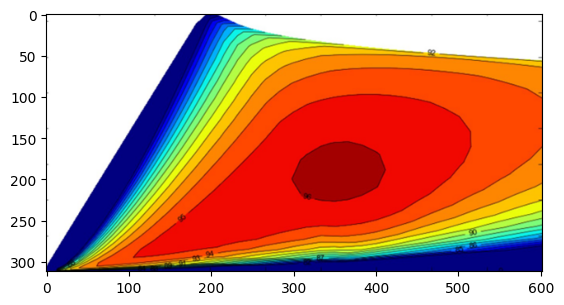

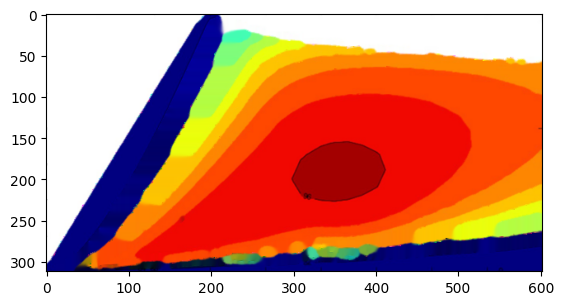

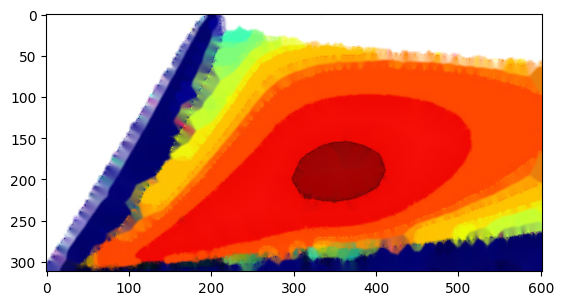

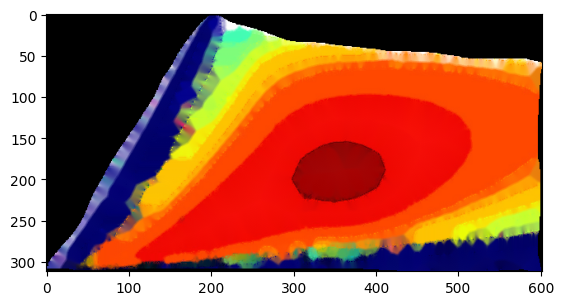

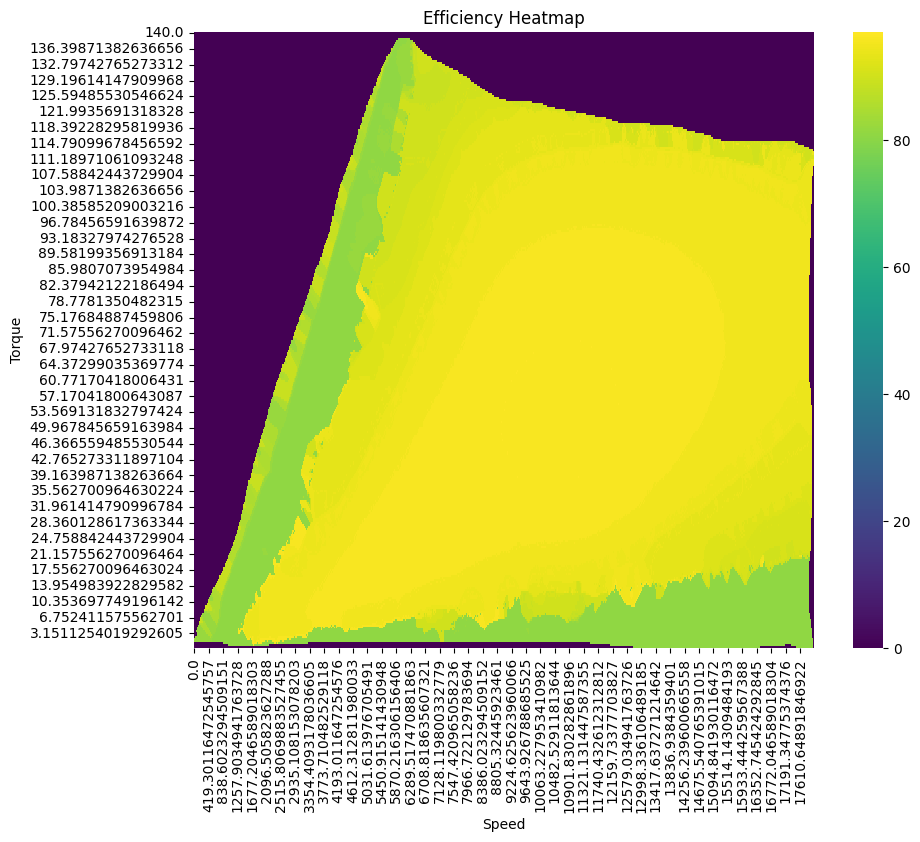

In [81]:
metadata = get_metadata(ID)
mask_roi = define_roi(ID)
scale, grayscale = get_scale(ID, metadata)
em = infill_text(ID)
plt.show()
plt.imshow(em)
nolines = infill_lines(em)
plt.show()
plt.imshow(nolines)
inscale = infill_not_in_scale(nolines, grayscale)
plt.show()
plt.imshow(inscale)
roi = apply_roi(inscale, mask_roi)
plt.show()
plt.imshow(roi)
efficiency_lookup_df = efficiency_lookup(roi, scale)
efficiency_heatmap(efficiency_lookup_df)

In [202]:
## notes
# make initial cropping etc part of a ui tool
# use cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) to grayscale instead of PIL
# the too black list may need some work, parameters etc, use rgb here now
# test out a gaussian convolution prior to edge detection
# infilling near bounding region is spurrious
# assume vertical scale bar (add option to rotate)
# better ranges
# rewrite to remove for loops, add vectorisation
# infill vs. mask throughout and not output
# address efficiency upper bound 93 for YASA
# heatmap for HDSR
# add promprt to get roi widget

In [16]:
def preprocess(ID):
    metadata = get_metadata(ID)
    scale, grayscale = get_scale(ID, metadata)
    em = infill_text(ID)
    nolines = infill_lines(em)
    processed_img = infill_not_in_scale(nolines, grayscale)
    plt.show()
    plt.imshow(processed_img)
    efficiency_lookup_df = efficiency_lookup(processed_img, scale)
    efficiency_heatmap(efficiency_lookup_df)

Looking for C:\Users\benst\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\benst\.keras-ocr\crnn_kurapan.h5
1/1 [==============================] - 3s 3s/step


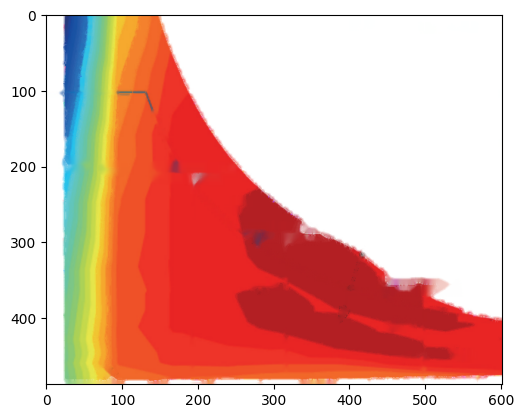

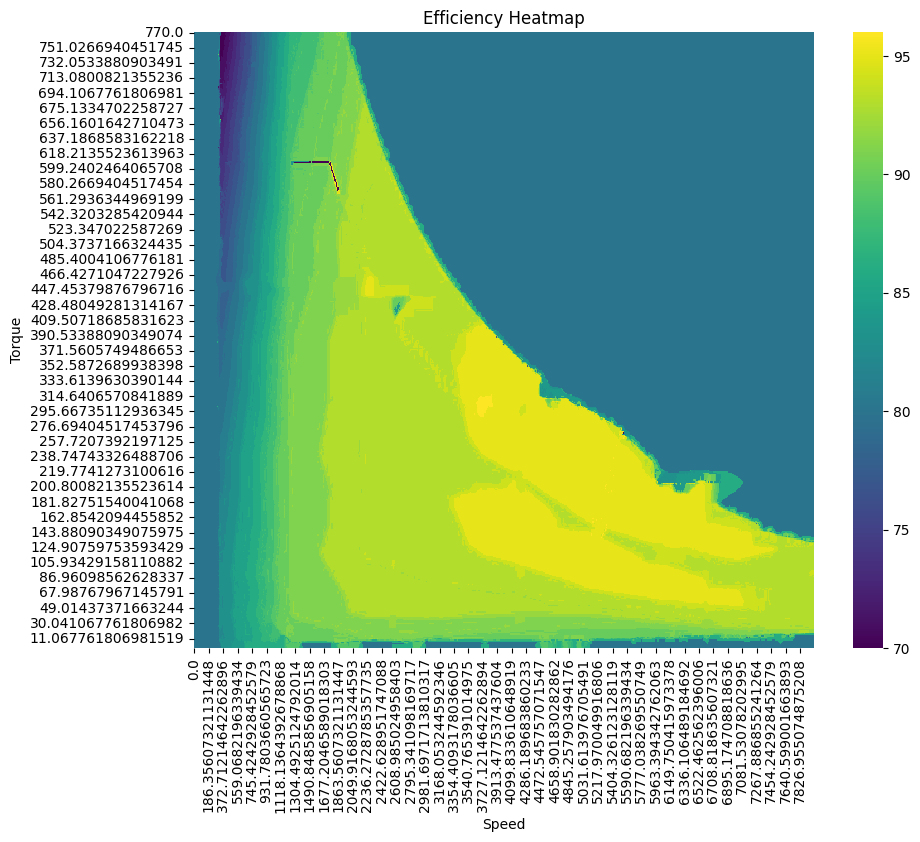

Looking for C:\Users\benst\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\benst\.keras-ocr\crnn_kurapan.h5
1/1 [==============================] - 2s 2s/step


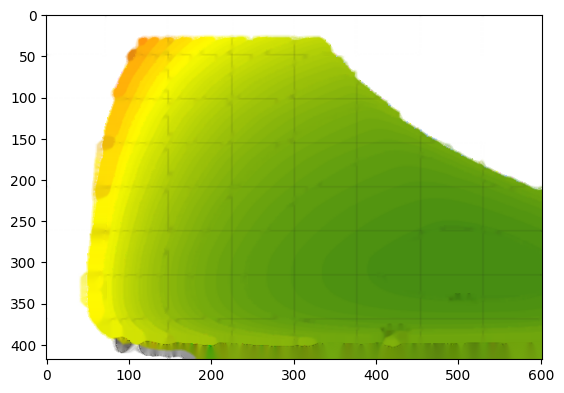

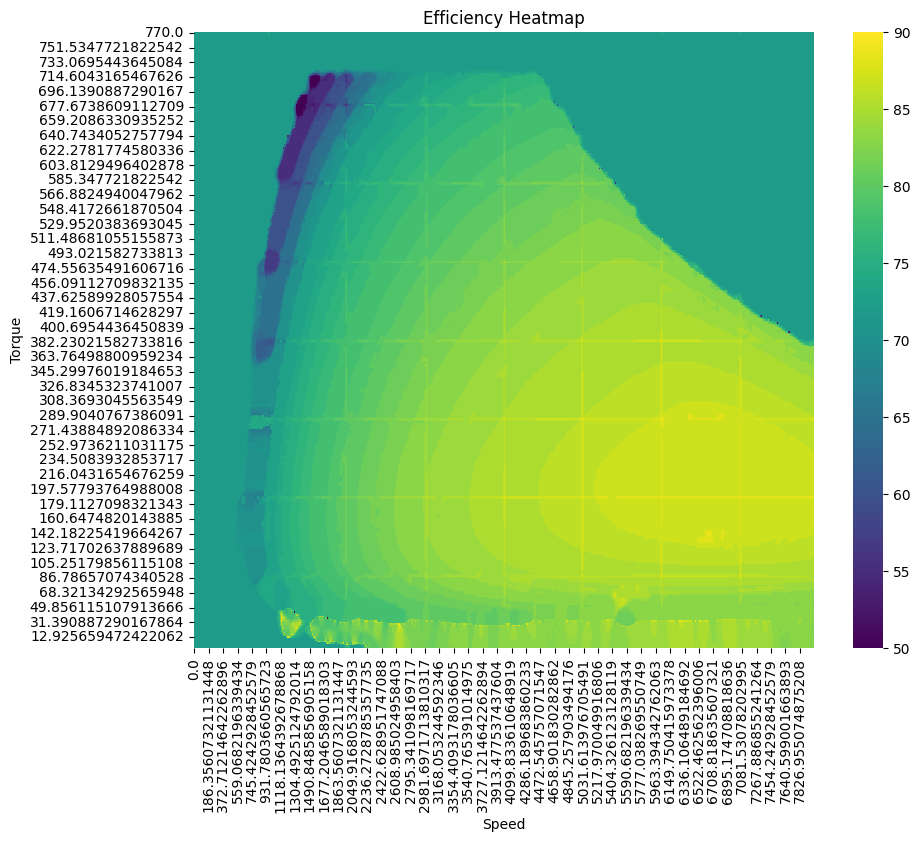

Looking for C:\Users\benst\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\benst\.keras-ocr\crnn_kurapan.h5
1/1 [==============================] - 3s 3s/step


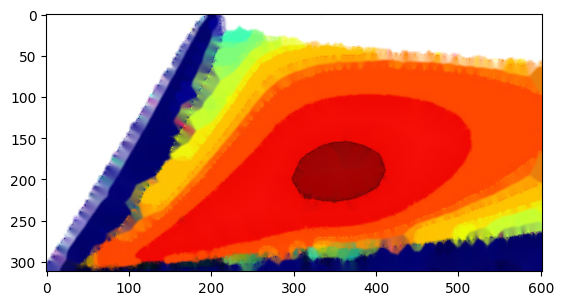

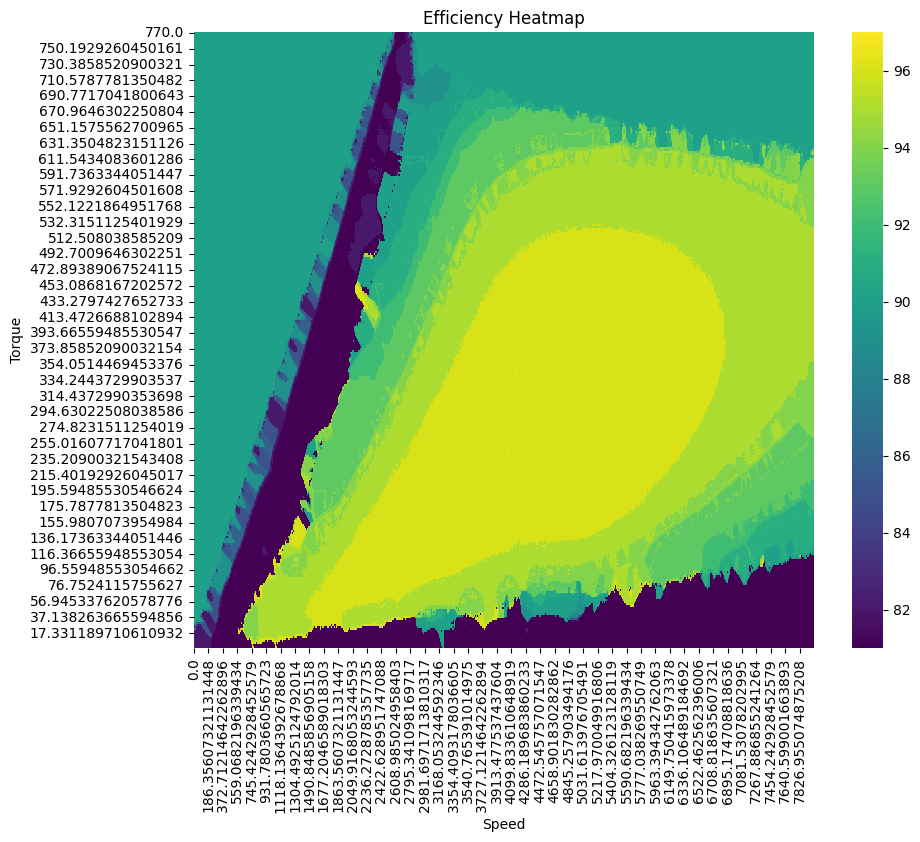

In [204]:
IDS = ['HDSRM300', 'YASA_P400', '180-100-009']
for ID in IDS:
    preprocess(ID)

## utility functions
- move to utils

In [52]:
def mark_point(image, y, x):
    cv2.circle(image, (x, y), 5, (0, 0, 255), -1)
    cv2.imshow('Image with Marked Point', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [206]:
"""
def get_scale(ID):

    scale_image = Image.open(os.path.join('inputs\scales', ID +'.png'))
    gs_scale_image = scale_image.convert("L")
    grayscale_array = np.array(gs_scale_image)


    array = np.array([x[0] for x in grayscale_array])
    seen = set()
    scale = []
    for i in array:
        if i not in seen:
            seen.add(i)
            scale.append(i)

    return scale

    def infill_not_in_scale(im, scale):

    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    _additional_gs = [250,251,252,253,254,255] # these are black and close to black

    # Define the predefined list of grayscale values
    scale += _additional_gs

    mask = np.ones_like(gray) * 255  # Initialize mask with all white pixels
    for value in scale:
        mask[gray == value] = 0  # Set pixels with predefined grayscale values to black in the mask

    inscale = cv2.inpaint(im, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    return inscale

    def infill_no_in_scale(im):

    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    black = [0,1,2,3,4] # these are black and close to black

    mask = np.ones_like(gray) * 255  # Initialize mask with all white pixels
    for value in black:
        mask[gray == value] = 0  # Set pixels with predefined grayscale values to black in the mask

    noblack = cv2.inpaint(im, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    return noblack

    plt.imshow(image[397][390].reshape((1, 1, 3)))

    # Create a mask where pixels with predefined RGB values are set to 0 (areas to inpaint)
mask = np.ones_like(image[:, :, 0], dtype=np.uint8) * 255
for color in scale[:,:3]:
    mask[np.all(image == color, axis=-1)] = 0

# Inpaint the image using the mask
inpaint_image = cv2.inpaint(image, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

plt.imshow(inpaint_image)
"""

'\ndef get_scale(ID):\n\n    scale_image = Image.open(os.path.join(\'inputs\\scales\', ID +\'.png\'))\n    gs_scale_image = scale_image.convert("L")\n    grayscale_array = np.array(gs_scale_image)\n\n\n    array = np.array([x[0] for x in grayscale_array])\n    seen = set()\n    scale = []\n    for i in array:\n        if i not in seen:\n            seen.add(i)\n            scale.append(i)\n\n    return scale\n\n    def infill_not_in_scale(im, scale):\n\n    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)\n\n    _additional_gs = [250,251,252,253,254,255] # these are black and close to black\n\n    # Define the predefined list of grayscale values\n    scale += _additional_gs\n\n    mask = np.ones_like(gray) * 255  # Initialize mask with all white pixels\n    for value in scale:\n        mask[gray == value] = 0  # Set pixels with predefined grayscale values to black in the mask\n\n    inscale = cv2.inpaint(im, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)\n\n    return inscale\n\n    def in

In [207]:
"""
def get_scale(ID, metadata):
    scale_image = keras_ocr.tools.read(os.path.join('inputs\scales', ID +'.png'))
    #scale_image = Image.open(os.path.join('inputs\scales', ID +'.png'))

    #gs_scale_image = scale_image.convert("L")
    gs_scale_image = cv2.cvtColor(scale_image, cv2.COLOR_BGR2GRAY)
    grayscale_array = np.array(gs_scale_image)
    array = np.array([x[0] for x in grayscale_array])
    seen = set()
    grayscale = []
    for i in array:
        if i not in seen:
            seen.add(i)
            grayscale.append(i)

    scale = np.array(scale_image)
    scale = scale[:,0,:3]

    su = metadata[metadata['Dim'] == 'SU']['z'].values[0]
    sl = metadata[metadata['Dim'] == 'SL']['z'].values[0]
    scale_range = su - sl

    scale_items = scale.shape[0]
    scale_fidelity = scale_range / scale_items
    z_values = (np.arange(1, scale_items + 1) * scale_fidelity) + sl
    z_values_df = pd.DataFrame(z_values, columns=['z'])
    scale_df = pd.DataFrame(scale, columns=['r', 'g', 'b'])
    scale_df = scale_df.join(z_values_df)
    scale_df = (scale_df.groupby(['r','g','b']).agg(z_mean=('z', 'mean'))).reset_index()
    scale = scale_df.values.astype(np.uint8)

    return scale, grayscale
"""

'\ndef get_scale(ID, metadata):\n    scale_image = keras_ocr.tools.read(os.path.join(\'inputs\\scales\', ID +\'.png\'))\n    #scale_image = Image.open(os.path.join(\'inputs\\scales\', ID +\'.png\'))\n\n    #gs_scale_image = scale_image.convert("L")\n    gs_scale_image = cv2.cvtColor(scale_image, cv2.COLOR_BGR2GRAY)\n    grayscale_array = np.array(gs_scale_image)\n    array = np.array([x[0] for x in grayscale_array])\n    seen = set()\n    grayscale = []\n    for i in array:\n        if i not in seen:\n            seen.add(i)\n            grayscale.append(i)\n\n    scale = np.array(scale_image)\n    scale = scale[:,0,:3]\n\n    su = metadata[metadata[\'Dim\'] == \'SU\'][\'z\'].values[0]\n    sl = metadata[metadata[\'Dim\'] == \'SL\'][\'z\'].values[0]\n    scale_range = su - sl\n\n    scale_items = scale.shape[0]\n    scale_fidelity = scale_range / scale_items\n    z_values = (np.arange(1, scale_items + 1) * scale_fidelity) + sl\n    z_values_df = pd.DataFrame(z_values, columns=[\'z\'])\

In [ ]:
"""
import cv2
import numpy as np

# Load the heatmap image
heatmap = cv2.imread(os.path.join('inputs\efficiency_maps', ID +'.png'))

# Convert the image to grayscale
gray_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY)

# Threshold the image to extract the ROI
_, thresh = cv2.threshold(gray_heatmap, 0, 255, cv2.THRESH_BINARY)

# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the contour representing the ROI (you may need to adjust this based on your specific case)
roi_contour = max(contours, key=cv2.contourArea)

# Get the bounding box coordinates of the ROI
x, y, w, h = cv2.boundingRect(roi_contour)

# Draw the bounding box on the heatmap
cv2.rectangle(heatmap, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the heatmap with bounding box
cv2.imshow('Heatmap with ROI Bounding Box', heatmap)
cv2.waitKey(0)
cv2.destroyAllWindows()
"""